In [23]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/home/ubuntu/varios/skforecast'

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# set theme for matplotlib
plt.style.use('seaborn-v0_8-darkgrid')

from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregCustomDiff import ForecasterAutoregCustomDiff
from sklearn.linear_model import LinearRegression   
from sklearn.ensemble import RandomForestRegressor
from lineartree import LinearForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

Train dates : 1991-07-01 00:00:00 --- 2003-03-01 00:00:00  (n=141)
Test dates  : 2003-04-01 00:00:00 --- 2008-06-01 00:00:00  (n=63)


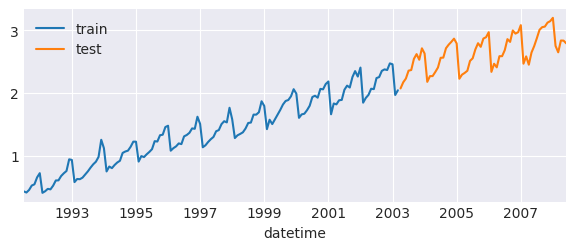

In [25]:
# Download data
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/'
    'data/h2o.csv'
)
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Add a smooth positive trend
# ==============================================================================
t = np.arange(len(data))
data = data + 0.01 * t

# Data partition train-test
# ==============================================================================
end_train = '2003-03-01 23:59:00'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  " 
    f"(n={len(data.loc[:end_train])})")
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
ax.legend();

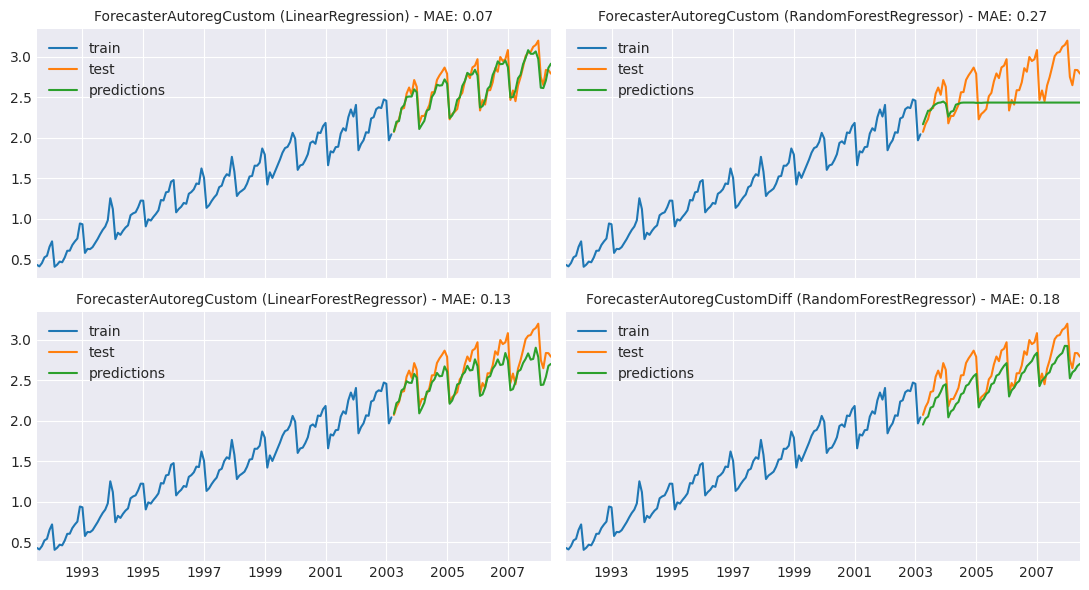

In [26]:
# Compare predictions of different models
# ==============================================================================

def create_predictors(y):
    """
    Create first 15 lags of a time series.
    Calculate moving average with window 20.
    """

    lags = y[-1:-16:-1]     # window_size = 10
    mean = np.mean(y[-21:]) # window_size = 20
    predictors = np.hstack([lags, mean])

    return predictors

regressors = [
    LinearRegression(),
    RandomForestRegressor(random_state=123),
    LinearForestRegressor(base_estimator=LinearRegression(), max_features='sqrt')
]

fig, ax = plt.subplots(2, 2, figsize=(11, 6), sharex=True, sharey=True)
ax = ax.ravel()

# ForecasterAutoreg Custom
for i, regressor in enumerate(regressors):
    forecaster = ForecasterAutoregCustom(
        regressor=regressor,
        fun_predictors=create_predictors,
        window_size=23
    )
    forecaster.fit(y=data.loc[:end_train])
    predictions = forecaster.predict(steps=len(data.loc[end_train:]))
    error = mean_absolute_error(data.loc[end_train:], predictions)
    data.loc[:end_train].plot(ax=ax[i], label='train')
    data.loc[end_train:].plot(ax=ax[i], label='test')
    predictions.plot(ax=ax[i], label='predictions')
    ax[i].set_title(
        f'ForecasterAutoregCustom ({forecaster.regressor.__class__.__name__}) - MAE: {error:.2f}',
        size=10
    )
    ax[i].set_xlabel('')
    ax[i].legend()

# ForecasterAutoregDiff with random forest
forecaster = ForecasterAutoregCustomDiff(
                 regressor       = RandomForestRegressor(random_state=123),
                 fun_predictors  = create_predictors,
                 window_size     = 30,
                 differentiation = 1
            )
forecaster.fit(y=data.loc[:end_train])
predictions = forecaster.predict(steps=len(data.loc[end_train:]))
error = mean_absolute_error(data.loc[end_train:], predictions)
data.loc[:end_train].plot(ax=ax[3], label='train')
data.loc[end_train:].plot(ax=ax[3], label='test')
predictions.plot(ax=ax[3], label='predictions')
ax[3].set_title(
        f'ForecasterAutoregCustomDiff ({forecaster.regressor.__class__.__name__}) - MAE: {error:.2f}',
        size=10
    )
ax[3].set_xlabel('')
ax[3].legend()

fig.tight_layout()

Train dates : 1949-01-01 00:00:00 --- 1957-01-01 00:00:00  (n=97)
Test dates  : 1957-01-01 00:00:00 --- 1960-12-01 00:00:00  (n=48)


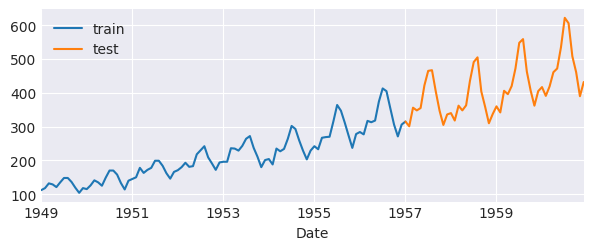

In [39]:
# Download data
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/'
    'master/data/AirPassengers.csv'
)
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m')
data = data.set_index('Date')
data = data.asfreq('MS')
data = data['Passengers']
data = data.sort_index()


# # Data partition train-test
# # ==============================================================================
end_train = '1957-01-01'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  " 
    f"(n={len(data.loc[:end_train])})")
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
ax.legend();

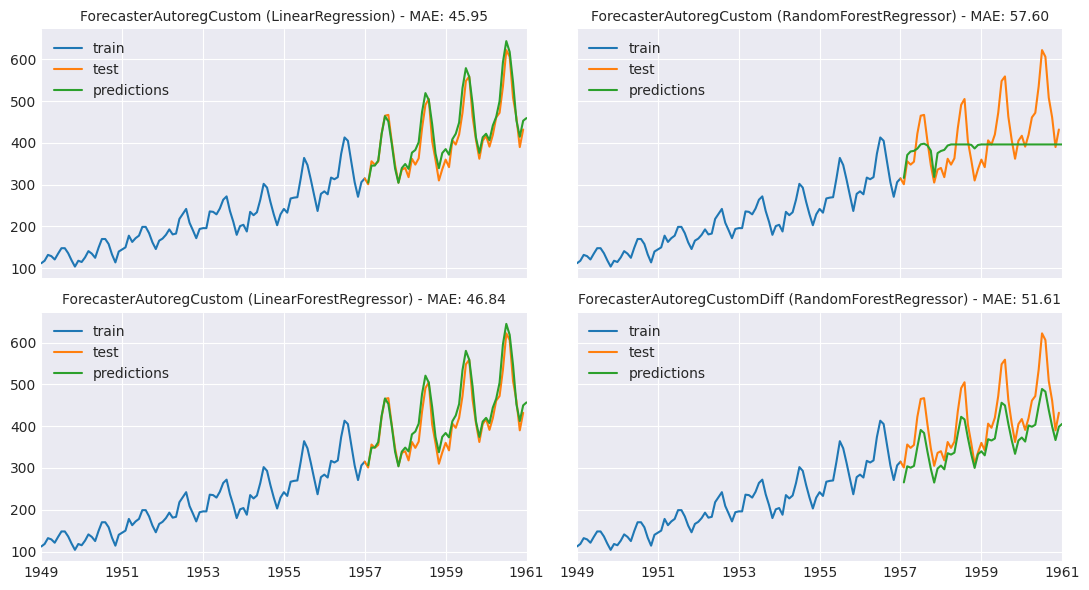

In [40]:
# Compare predictions of different models
# ==============================================================================

def create_predictors(y):
    """
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    """

    lags = y[-1:-16:-1]     # window_size = 10
    mean = np.mean(y[-5:]) # window_size = 20
    predictors = np.hstack([lags, mean])

    return predictors

regressors = [
    LinearRegression(),
    RandomForestRegressor(random_state=123),
    LinearForestRegressor(base_estimator=LinearRegression(), max_features='sqrt')
]

fig, ax = plt.subplots(2, 2, figsize=(11, 6), sharex=True, sharey=True)
ax = ax.ravel()

# ForecasterAutoreg Custom
for i, regressor in enumerate(regressors):
    forecaster = ForecasterAutoregCustom(
        regressor=regressor,
        fun_predictors=create_predictors,
        window_size=23
    )
    forecaster.fit(y=data.loc[:end_train])
    predictions = forecaster.predict(steps=len(data.loc[end_train:]))
    error = mean_absolute_error(data.loc[end_train:], predictions)
    data.loc[:end_train].plot(ax=ax[i], label='train')
    data.loc[end_train:].plot(ax=ax[i], label='test')
    predictions.plot(ax=ax[i], label='predictions')
    ax[i].set_title(
        f'ForecasterAutoregCustom ({forecaster.regressor.__class__.__name__}) - MAE: {error:.2f}',
        size=10
    )
    ax[i].set_xlabel('')
    ax[i].legend()

# ForecasterAutoregDiff with random forest
forecaster = ForecasterAutoregCustomDiff(
                 regressor       = RandomForestRegressor(random_state=123),
                 fun_predictors  = create_predictors,
                 window_size     = 15,
                 differentiation = 1
            )
forecaster.fit(y=data.loc[:end_train])
predictions = forecaster.predict(steps=len(data.loc[end_train:]))
error = mean_absolute_error(data.loc[end_train:], predictions)
data.loc[:end_train].plot(ax=ax[3], label='train')
data.loc[end_train:].plot(ax=ax[3], label='test')
predictions.plot(ax=ax[3], label='predictions')
ax[3].set_title(
        f'ForecasterAutoregCustomDiff ({forecaster.regressor.__class__.__name__}) - MAE: {error:.2f}',
        size=10
    )
ax[3].set_xlabel('')
ax[3].legend()

fig.tight_layout()

/home/ubuntu/anaconda3/envs/skforecast_10_py11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Predictions sarimax


1955-02-01    227.287610
1955-03-01    259.079682
1955-04-01    254.483809
1955-05-01    261.370308
Freq: MS, Name: predicted_mean, dtype: float64

Predictions Forecaster


1955-02-01    182.204037
1955-03-01    216.819350
1955-04-01    212.956124
1955-05-01    222.738937
1955-06-01    255.556600
                 ...    
1960-09-01    372.748645
1960-10-01    353.813229
1960-11-01    327.497545
1960-12-01    348.138728
1961-01-01    342.750506
Freq: MS, Name: pred, Length: 72, dtype: float64

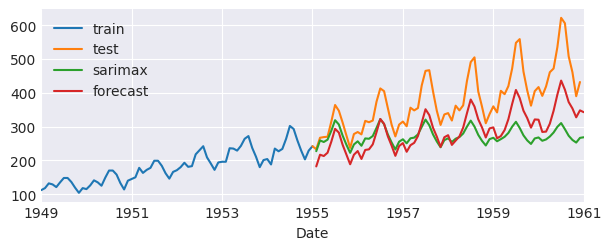

In [34]:
# Compare predictions with an arima (lags, 1, 0)
# ==============================================================================
from statsmodels.tsa.statespace.sarimax import SARIMAX
steps = len(data.loc[end_train:])

sarimax = SARIMAX(data.loc[:end_train], order=(12, 1, 0))
res_sarimax = sarimax.fit(disp=False, maxiter=1000)
predictions_sarimax = res_sarimax.get_forecast(steps).predicted_mean
print("Predictions sarimax")
display(predictions_sarimax.head(4))

def create_predictors(y):
    """
    Create first 12 lags of a time series.
    Calculate moving average with window 1.
    """

    lags = y[-1:-13:-1]   

    return lags

forecaster = ForecasterAutoregCustomDiff(
                 regressor       = LinearRegression(),
                 window_size     = 12,
                 differentiation = 1,
                 fun_predictors  = create_predictors            )
            
forecaster.fit(y=data.loc[:end_train])
print("Predictions Forecaster")
predictions = forecaster.predict(steps)
display(predictions)
fig, ax = plt.subplots(figsize=(7, 2.5))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions_sarimax.plot(ax=ax, label='sarimax')
predictions.plot(ax=ax, label='forecast')
ax.legend();